In [1]:
# importing the required libraries
import glob
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import torch
from torchvision import transforms, utils
from torch.utils.data import Dataset, DataLoader

%load_ext autoreload
%autoreload 2

Let's load in our training data and display some stats about that data to make sure it's been loaded in correctly!

In [2]:
keypoints_csv_path = os.path.join("../../data", "training_frames_keypoints.csv")
training_data_dir = os.path.join("../../data", "training")
print(keypoints_csv_path)

../../data/training_frames_keypoints.csv


In [3]:
key_pts_frame = pd.read_csv(keypoints_csv_path, index_col=0)
key_pts_frame.head()

,0,1,2,3,4,5,6,7,8,9,...,126,127,128,129,130,131,132,133,134,135
Luis_Fonsi_21.jpg,45.0,98.0,47.0,106.0,49.0,110.0,53.0,119.0,56.0,125.0,...,83.0,119.0,90.0,117.0,83.0,119.0,81.0,122.0,77.0,122.0
Lincoln_Chafee_52.jpg,41.0,83.0,43.0,91.0,45.0,100.0,47.0,108.0,51.0,119.0,...,85.0,122.0,94.0,120.0,85.0,122.0,83.0,122.0,79.0,122.0
Valerie_Harper_30.jpg,56.0,69.0,56.0,77.0,56.0,86.0,56.0,94.0,58.0,103.0,...,79.0,105.0,86.0,108.0,77.0,105.0,75.0,105.0,73.0,105.0
Angelo_Reyes_22.jpg,61.0,80.0,58.0,95.0,58.0,108.0,58.0,120.0,58.0,132.0,...,98.0,136.0,107.0,139.0,95.0,139.0,91.0,139.0,85.0,136.0
Kristen_Breitweiser_11.jpg,58.0,94.0,58.0,104.0,60.0,113.0,62.0,121.0,67.0,130.0,...,92.0,117.0,103.0,118.0,92.0,120.0,88.0,122.0,84.0,122.0


In [4]:
key_pts_frame.shape

(3462, 136)

In [5]:
n = 0
image_name = key_pts_frame.iloc[n, 0]
key_pts = key_pts_frame.iloc[n, :].values  # ignore column name
# Convert the flatten version to a set of (x, y) coordinates
key_pts = key_pts.astype("float").reshape(-1, 2)

In [6]:
# printing out some stats about the data
print("Number of images: ", len(key_pts_frame))
print("Number of keypoints per image: ", len(key_pts))

Number of images:  3462
Number of keypoints per image:  68


## Look at some images

Below, is a function `show_keypoints` that takes in an image and keypoints and displays them.  As you look at this data, **note that these images are not all of the same size**, and neither are the faces! To eventually train a neural network on these images, we'll need to standardize their shape.

In [7]:
def show_keypoints(image, key_pts):
    """Show image with keypoints"""
    plt.imshow(image)
    plt.scatter(key_pts[:, 0], key_pts[:, 1], s=20, marker=".", c="m")
    # print(type(image), image.shape)

In [8]:
class FacialKeypointsDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.key_pts_frame = pd.read_csv(csv_file, index_col=0)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.key_pts_frame)

    def __getitem__(self, idx):
        
        image_name = os.path.join(self.root_dir, self.key_pts_frame.index[idx]).strip()

        image = mpimg.imread(image_name)

        # if image has an alpha color channel, get rid of it
        if image.shape[2] == 4:
            image = image[:, :, 0:3]

        key_pts = self.key_pts_frame.iloc[idx, :].values
        key_pts = key_pts.astype("float").reshape(-1, 2)
        sample = {"image": image, "keypoints": key_pts}

        if self.transform:
            sample = self.transform(sample)

        return sample

I put the above class in `facial_keypoints_dataset.py` the to keep modularity. Now that we've defined this class, let's instantiate the dataset and display some images.

In [9]:
# Construct the dataset
face_dataset = FacialKeypointsDataset(
    csv_file=keypoints_csv_path, root_dir=training_data_dir
)

# print some stats about the dataset
print("Length of dataset: ", len(face_dataset))

Length of dataset:  3462


0 (234, 223, 3) (68, 2)
1 (198, 173, 3) (68, 2)
2 (155, 157, 3) (68, 2)


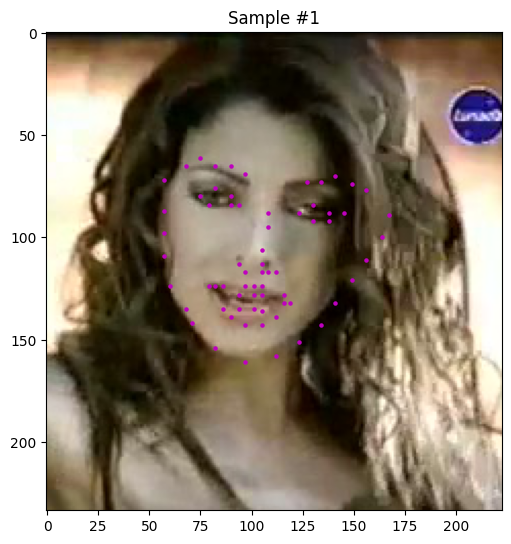

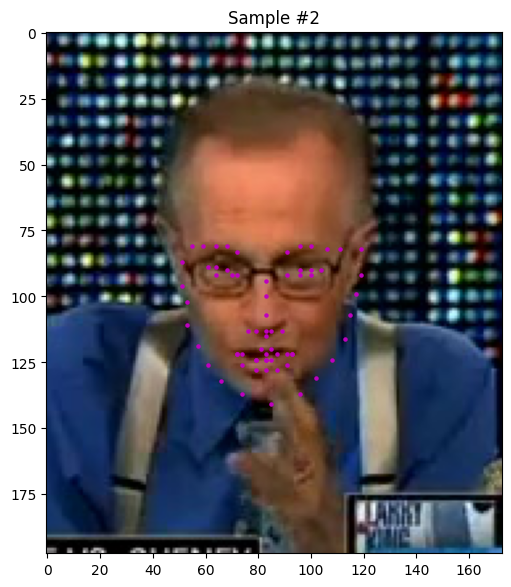

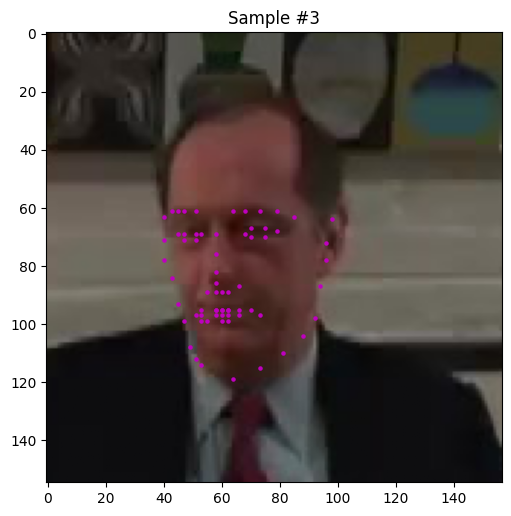

In [10]:
# Displaying a few of the images from the dataset
num_to_display = 3

for i in range(num_to_display):

    # define the size of images
    fig = plt.figure(figsize=(20, 10))

    # randomly select a sample
    rand_i = np.random.randint(0, len(face_dataset))
    sample = face_dataset[rand_i]  # call __getitem__

    # print the shape of the image and keypoints
    print(i, sample["image"].shape, sample["keypoints"].shape)

    ax = plt.subplot(1, num_to_display, i + 1)
    ax.set_title("Sample #{}".format(i+1))

    # Using the same display function, defined earlier
    show_keypoints(sample["image"], sample["keypoints"])

## Transforms

Now, the images above are not of the same size, and neural networks often expect images that are standardized; a fixed size, with a normalized range for color ranges and coordinates, and (for PyTorch) converted from numpy lists and arrays to Tensors.

Therefore, we will need to write some pre-processing code.
Let's create four transforms:

-  ``Normalize``: to convert a color image to grayscale values with a range of [0,1] and normalize the keypoints to be in a range of about [-1, 1]
-  ``Rescale``: to rescale an image to a desired size.
-  ``RandomCrop``: to crop an image randomly.
-  ``ToTensor``: to convert numpy images to torch images.


We will write them as callable classes instead of simple functions so
that parameters of the transform need not be passed everytime it's
called. For this, we just need to implement ``__call__`` method and 
(if we require parameters to be passed in), the ``__init__`` method. 
We can then use a transform like this:

    tx = Transform(params)
    transformed_sample = tx(sample)

Observe below how these transforms are generally applied to both the image and its keypoints.



In [11]:
class Normalize(object):
    """Convert a color image to grayscale and normalize the color range to [0,1]."""

    def __call__(self, sample):
        image, key_pts = sample["image"], sample["keypoints"]

        # print(type(image), image.shape)

        image_copy = np.copy(image)
        key_pts_copy = np.copy(key_pts)

        # convert image to grayscale
        # image_copy = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2GRAY)

        # scale color range from [0, 255] to [0, 1]
        image_copy = image_copy / 255.0

        # scale keypoints to be centered around 0 with a range of [-1, 1]
        # mean = 100, sqrt = 50, so, pts should be (pts - 100)/50
        key_pts_copy = (key_pts_copy - 100) / 50.0

        # print(type(image), image.shape)

        return {"image": image_copy, "keypoints": key_pts_copy}


class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, key_pts = sample["image"], sample["keypoints"]
 
        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = cv2.resize(np.array(image), (new_w, new_h))

        # scale the pts, too
        key_pts = key_pts * [new_w / w, new_h / h]

        return {"image": img, "keypoints": key_pts}


class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, key_pts = sample["image"], sample["keypoints"]

        # print(type(image), image.shape)    
        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top : top + new_h, left : left + new_w]

        key_pts = key_pts - [left, top]

        return {"image": image, "keypoints": key_pts}


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, key_pts = sample["image"], sample["keypoints"]
        
        # print(type(image), image.shape)
        # if image has no grayscale color channel, add one
        if len(image.shape) == 2:
            # add that third color dim
            image = image.reshape(image.shape[0], image.shape[1], 1)

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))

        # print(type(image), image.shape)

        return {
            "image": torch.from_numpy(image),
            "keypoints": torch.from_numpy(key_pts),
        }

In [12]:
class RescaleWithPadding(object):
    """Rescale the image in a sample to a given size with padding.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, key_pts = sample["image"], sample["keypoints"]

        if isinstance(key_pts, torch.Tensor):            
            key_pts = key_pts.numpy()
        h, w = image.shape[1:3]

        key_pts = (key_pts * 50) + 100
        
        added_padding = []
        if isinstance(self.output_size, int):
            if h > w:
                pad_size = h - w
                pad_left = pad_size // 2
                pad_right = pad_size - pad_left
                image = np.pad(image, ((0, 0), (0, 0), (pad_left, pad_right)), mode='constant')
                # new_h, new_w = self.output_size, int(self.output_size * h / w)
                new_h, new_w = self.output_size, self.output_size
                added_padding = [0, pad_size]
            else:
                pad_size = w - h
                pad_top = pad_size // 2
                pad_bottom = pad_size - pad_top
                image = np.pad(image, ((0, 0), (pad_top, pad_bottom), (0, 0)), mode='constant')
                new_h, new_w = self.output_size, self.output_size
                # new_h, new_w = int(self.output_size * h / w), self.output_size
                added_padding = [pad_size, 0]
        else:
            new_h, new_w = self.output_size, self.output_size
            added_padding = [0, 0]

        # print(image.shape)
        image = image.transpose((1, 2, 0))
        # Resize the image
        img = cv2.resize(image, (new_w, new_h))

        # Scale the keypoints
        # key_pts = key_pts * torch.tensor([new_w / (w + 0.5 * added_padding[1]), new_h / (h + 0.5 * added_padding[0])])
        key_pts = key_pts * [new_w / (w + 0.5 * added_padding[1]), new_h / (h + 0.5 * added_padding[0])]
        
        return {"image": img, "keypoints": key_pts}

In [13]:
from torchvision.transforms import v2

class KeypointsToTensor(object):
    def __init__(self):
        pass

    def __call__(self, sample):
        image, keypoints = sample['image'], sample['keypoints']

        # Convert image to tensor
        image = transforms.ToTensor()(image)

        # Create a black image
        black_image = torch.zeros_like(image)

        # Scale keypoints to range [0, 1]
        keypoints = keypoints / [image.shape[2], image.shape[1]]

        # Draw keypoints on the black image
        for keypoint in keypoints:
            x, y = keypoint
            black_image[0, int(y * image.shape[1]), int(x * image.shape[2])] = 1.0  # Setting red channel to 1.0

        return black_image

/apps/local/shared/CV701_Fall23/CV701_env/lib/python3.8/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/apps/local/shared/CV701_Fall23/CV701_env/lib/python3.8/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Pl

In [14]:
class FaceCrop(object):
    def __init__(self):
        pass
    
    def __call__(self, sample):
        image, keypoints = sample['image'], sample['keypoints']

        # Convert image to tensor
        # print(type(image), image.shape)
        
        image = transforms.ToTensor()(image)

        # Convert torch tensor to NumPy array for OpenCV operations
        image_np = image.permute(1, 2, 0).numpy()

        # Extract bounding box coordinates around keypoints
        x_min, y_min = keypoints.min(axis=0)
        x_max, y_max = keypoints.max(axis=0)

        # Pad the bounding box to include the entire face region
        padding = 0.2  # Adjust padding as needed
        x_min = max(0, int(x_min - padding * (x_max - x_min)))
        y_min = max(0, int(y_min - padding * (y_max - y_min)))
        x_max = min(image_np.shape[1], int(x_max + padding * (x_max - x_min)))
        y_max = min(image_np.shape[0], int(y_max + padding * (y_max - y_min)))

        # Crop the face region without resizing
        face_roi = image_np[y_min:y_max, x_min:x_max, :]

        # Adjust keypoints based on the crop
        keypoints -= [x_min, y_min]

        # Convert the result back to torch tensor
        face_cropped = torch.from_numpy(face_roi).float()

        return {'image': face_cropped.numpy(), 'keypoints': keypoints}

## Test out the transforms

Let's test these transforms out to make sure they behave as expected. I put all the above transforms plus several other transformations in the **custom_transforms.py** file. Note that, **order of transformation does matter**. For example, we cannot crop a image using a value smaller than the original image (and the original images vary in size!), but, if we first rescale the original image, we can then crop it to any size smaller than the rescaled size.

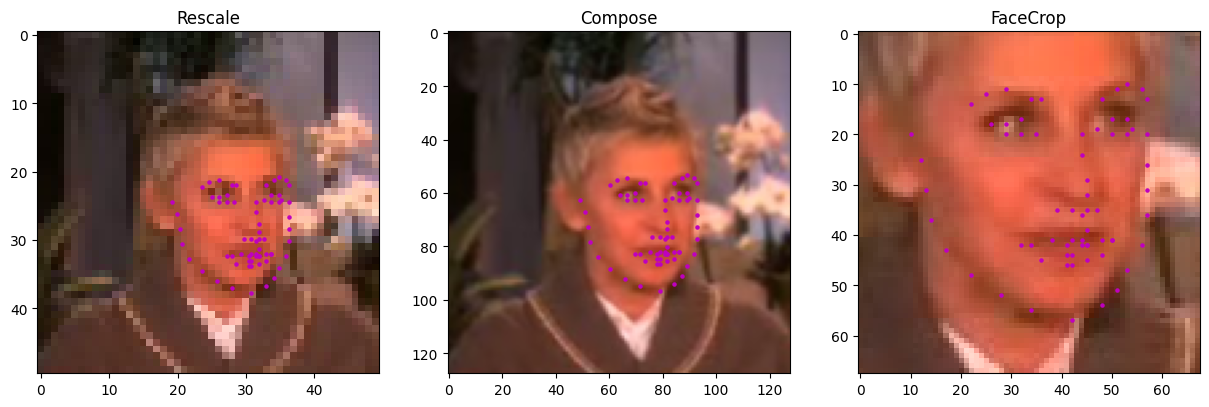

In [15]:
rescale = Rescale(50)  # call the __init__ method
composed = transforms.Compose([Rescale(224), Rescale(128)])
faceCrop = FaceCrop()

# apply the transforms to a sample image
test_num = 300
sample = face_dataset[test_num]

fig = plt.figure(figsize=(15,8))
plt.tight_layout()
# for i, tx in enumerate([rescale, crop, composed]):
for i, tx in enumerate([rescale, composed, faceCrop]):
    transformed_sample = tx(sample)

    ax = plt.subplot(1, 3, i + 1)
    ax.set_title(type(tx).__name__)
    show_keypoints(transformed_sample["image"], transformed_sample["keypoints"])

plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


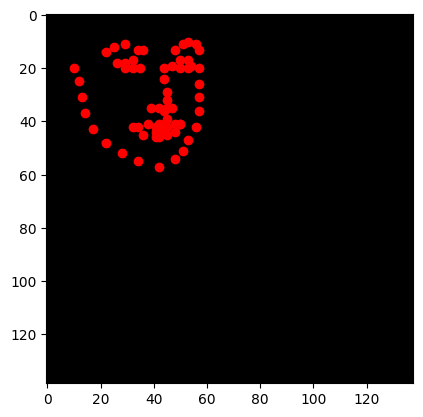

In [16]:
composed_transform = v2.Compose([
    KeypointsToTensor(),
    v2.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

result = composed_transform(sample)

# Display the result using matplotlib
plt.imshow(result.permute(1, 2, 0)) 
plt.scatter(sample['keypoints'][:, 0], sample['keypoints'][:, 1], c='red', marker='o')
plt.show()

## Creating the transformed dataset

Now, we apply the transforms in order to get grayscale images of the same shape. We verify our transform works by printing out the shape of the resulting data (printing out a few examples will give us a consistent tensor size).

In [17]:
# defining the data tranform
# order matters! i.e. rescaling should come before a smaller crop
data_transform = transforms.Compose(
    [FaceCrop(), Normalize(), ToTensor()]
)

# creating the transformed dataset
transformed_dataset = FacialKeypointsDataset(
    csv_file=keypoints_csv_path,
    root_dir=training_data_dir,
    transform=data_transform,
)

In [18]:
# printing some stats about the transformed data
print("Number of images: ", len(transformed_dataset))

file_names = pd.read_csv(keypoints_csv_path).iloc[:,0].to_list()

data = []
scaled_images = []

# making sure that the sample tensors are of the expected size
for i in range(len(transformed_dataset)):
# for i in range(5):

    try:

        sample = transformed_dataset[i]
        rescaleWpadding = RescaleWithPadding(224)
        sample = rescaleWpadding(sample)
        scaled_images.append(sample["image"])

        row = [file_names[i]]
        row.extend(np.round(sample["keypoints"].flatten().tolist(), decimals=0))

        data.append(row)

    except:
        print(f"Problem with image {i}")

Number of images:  3462


In [19]:
columns = [""]
columns.extend(list(range(0,136)))

df = pd.DataFrame(data, columns=columns)

# Save the DataFrame to a CSV file
df.to_csv('output_train.csv', index=False)

In [20]:
from PIL import Image
# Create a folder to save the images
folder_path = 'cropped_face_first_padding_resize'
file_names = pd.read_csv(keypoints_csv_path).iloc[:,0].to_list()

os.makedirs(folder_path, exist_ok=True)

# Save each array as an image in the folder

for i, array in enumerate(scaled_images):
    # print(array.shape)
    # print(array[:, :, 0] * 25500)
    image = Image.fromarray((array * 25500).astype(np.uint8))
    image_path = os.path.join(folder_path, f'{file_names[i]}')
    image.save(image_path)

print(f'Images saved in {folder_path}')

Images saved in cropped_face_first_padding_resize


In [21]:
crop_paddind_resize_keypoints_csv_path = os.path.join("../task1", "output_train.csv")
crop_paddind_resize_training_data_dir = os.path.join("../task1", "cropped_face_first_padding_resize")
print(crop_paddind_resize_keypoints_csv_path)

../task1/output_train.csv


In [22]:
# Construct the dataset
crop_paddind_resize_face_dataset = FacialKeypointsDataset(
    csv_file=crop_paddind_resize_keypoints_csv_path, root_dir=crop_paddind_resize_training_data_dir
)

# print some stats about the dataset
print("Length of dataset: ", len(crop_paddind_resize_face_dataset))

Length of dataset:  3462


0 (224, 224, 3) (68, 2)
1 (224, 224, 3) (68, 2)
2 (224, 224, 3) (68, 2)


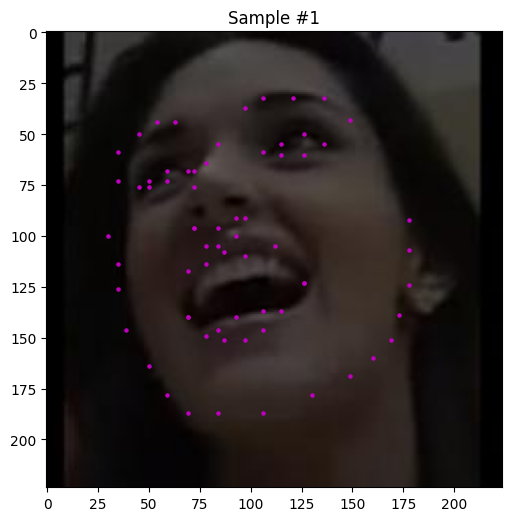

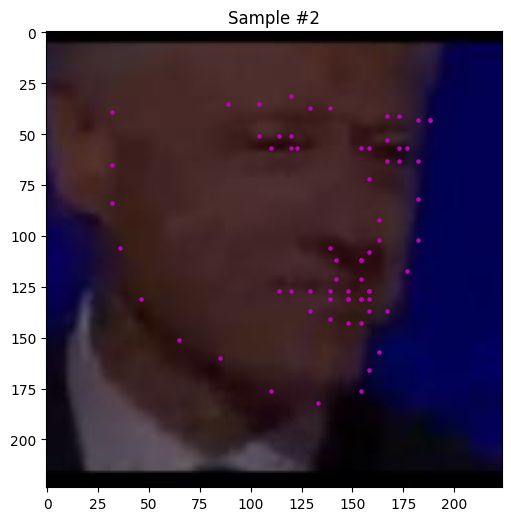

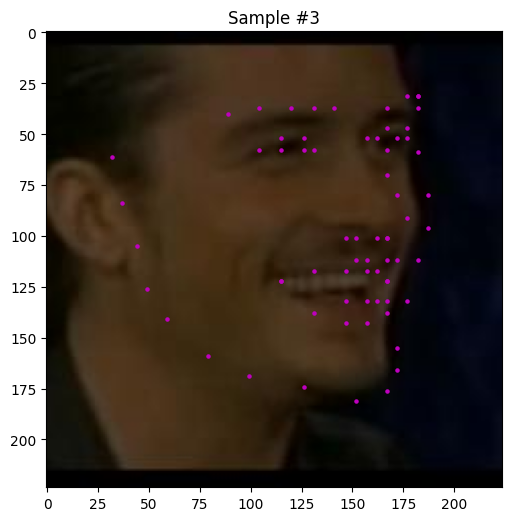

In [23]:
# Displaying a few of the images from the dataset
num_to_display = 3

for i in range(num_to_display):

    # define the size of images
    fig = plt.figure(figsize=(20, 10))

    # randomly select a sample
    rand_i = np.random.randint(0, len(crop_paddind_resize_face_dataset))
    sample = crop_paddind_resize_face_dataset[rand_i]  # call __getitem__

    # print the shape of the image and keypoints
    print(i, sample["image"].shape, sample["keypoints"].shape)

    ax = plt.subplot(1, num_to_display, i + 1)
    ax.set_title("Sample #{}".format(i+1))

    # Using the same display function, defined earlier
    show_keypoints(sample["image"], sample["keypoints"])

In [24]:
keypoints_test_csv_path = os.path.join("../../data", "test_frames_keypoints.csv")
training_test_data_dir = os.path.join("../../data", "test")
print(keypoints_test_csv_path)

# defining the data tranform
# order matters! i.e. rescaling should come before a smaller crop
data_test_transform = transforms.Compose(
    [FaceCrop(), Normalize(), ToTensor()]
)

# creating the transformed dataset
transformed_test_dataset = FacialKeypointsDataset(
    csv_file=keypoints_test_csv_path,
    root_dir=training_test_data_dir,
    transform=data_test_transform,
)

../../data/test_frames_keypoints.csv


In [25]:
import traceback

# printing some stats about the transformed data
print("Number of images: ", len(transformed_test_dataset))

file_names = pd.read_csv(keypoints_test_csv_path).iloc[:,0].to_list()

data = []
scaled_images = []

# making sure that the sample tensors are of the expected size
for i in range(len(transformed_test_dataset)):
# for i in range(5):

    try:

        sample = transformed_test_dataset[i]

        rescaleWpadding = RescaleWithPadding(224)
        sample = rescaleWpadding(sample)
        scaled_images.append(sample["image"])

        row = [file_names[i]]
        row.extend(np.round(sample["keypoints"].flatten().tolist(), decimals=0))

        data.append(row)

    except:

        print(traceback.format_exc())
        print(f"Problem with image {i}")

Number of images:  770


In [26]:
columns = [""]
columns.extend(list(range(0,136)))

df = pd.DataFrame(data, columns=columns)

# Save the DataFrame to a CSV file
df.to_csv('output_test.csv', index=False)

In [27]:
from PIL import Image
# Create a folder to save the images
folder_path = 'test_cropped_face_first_padding_resize'
file_names = pd.read_csv(keypoints_test_csv_path).iloc[:,0].to_list()

os.makedirs(folder_path, exist_ok=True)

# Save each array as an image in the folder

for i, array in enumerate(scaled_images):
    # print(array.shape)
    # print(array[:, :, 0] * 25500)
    image = Image.fromarray((array * 25500).astype(np.uint8))
    image_path = os.path.join(folder_path, f'{file_names[i].strip()}')
    image.save(image_path)

print(f'Images saved in {folder_path}')

Images saved in test_cropped_face_first_padding_resize


In [28]:
crop_paddind_resize_keypoints_csv_path = os.path.join("../task1", "output_test.csv")
crop_paddind_resize_training_data_dir = os.path.join("../task1", "test_cropped_face_first_padding_resize")
print(crop_paddind_resize_keypoints_csv_path)

../task1/output_test.csv


In [29]:
# Construct the dataset
crop_paddind_resize_face_dataset_test = FacialKeypointsDataset(
    csv_file=crop_paddind_resize_keypoints_csv_path, root_dir=crop_paddind_resize_training_data_dir
)

# print some stats about the dataset
print("Length of dataset: ", len(crop_paddind_resize_face_dataset_test))

Length of dataset:  770


0 (224, 224, 3) (68, 2)
1 (224, 224, 3) (68, 2)
2 (224, 224, 3) (68, 2)


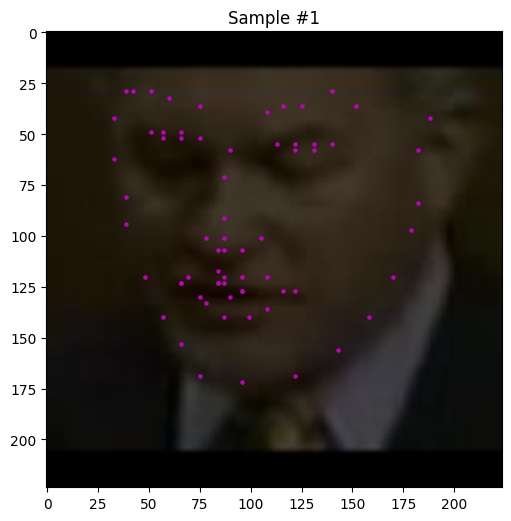

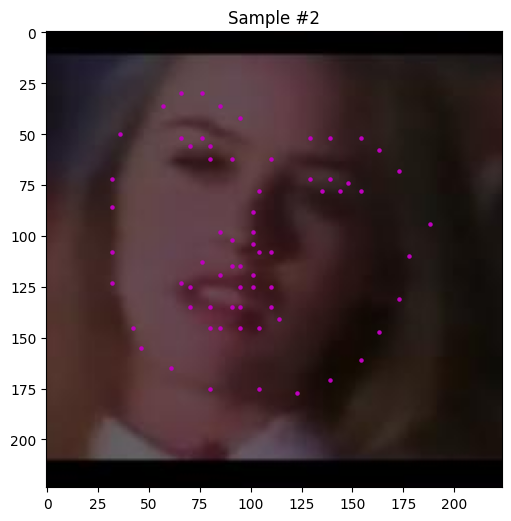

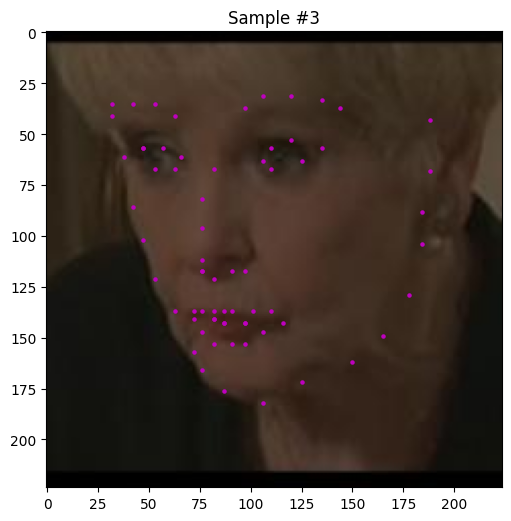

In [30]:
# Displaying a few of the images from the dataset
num_to_display = 3

for i in range(num_to_display):

    # define the size of images
    fig = plt.figure(figsize=(20, 10))

    # randomly select a sample
    rand_i = np.random.randint(0, len(crop_paddind_resize_face_dataset_test))
    sample = crop_paddind_resize_face_dataset[rand_i]  # call __getitem__

    # print the shape of the image and keypoints
    print(i, sample["image"].shape, sample["keypoints"].shape)

    ax = plt.subplot(1, num_to_display, i + 1)
    ax.set_title("Sample #{}".format(i+1))

    # Using the same display function, defined earlier
    show_keypoints(sample["image"], sample["keypoints"])